In [ ]:
'''Since the project is more about experiment, the code is not structured with well-defined classes and functions.
The code is divided into ??? parts.
'''

Missing values in each column:
 Transaction_ID    0
tmsp              0
country           0
amount            0
success           0
PSP               0
3D_secured        0
card              0
dtype: int64
The percentage of missing values in each column is:
 Transaction_ID    0.0
tmsp              0.0
country           0.0
amount            0.0
success           0.0
PSP               0.0
3D_secured        0.0
card              0.0
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Transaction_ID  50410 non-null  int64         
 1   tmsp            50410 non-null  datetime64[ns]
 2   country         50410 non-null  object        
 3   amount          50410 non-null  int64         
 4   success         50410 non-null  int64         
 5   PSP             50410 non-null  object        
 6   3D_secured      50410 

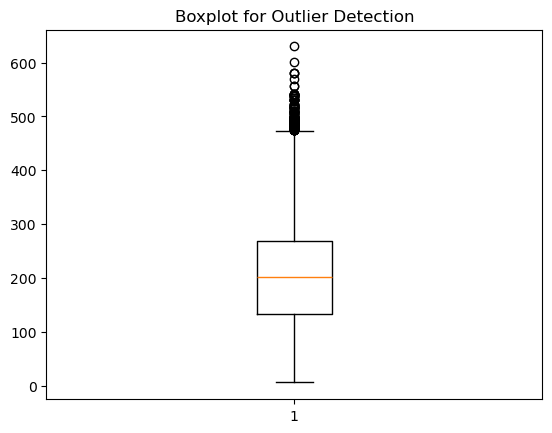

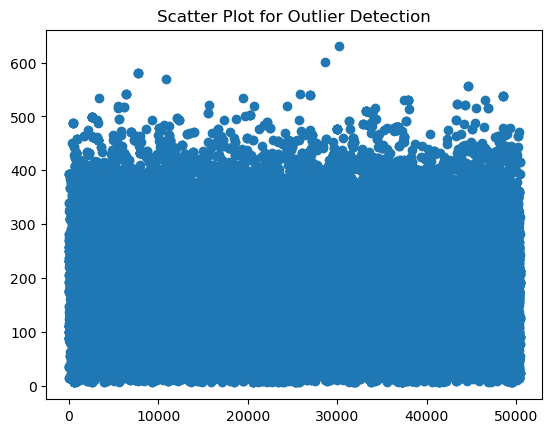

       Transaction_ID                tmsp      country  amount  success  \
2617             2617 2019-01-03 04:06:18  Switzerland     499        0   
2618             2618 2019-01-03 04:06:52  Switzerland     499        0   
2619             2619 2019-01-03 04:07:34  Switzerland     499        0   
2620             2620 2019-01-03 04:07:41  Switzerland     499        0   
2621             2621 2019-01-03 04:08:22  Switzerland     499        0   
...               ...                 ...          ...     ...      ...   
46842           46842 2019-02-24 15:54:11      Germany     515        0   
48555           48555 2019-02-26 17:55:00      Germany     538        0   
48556           48556 2019-02-26 17:55:06      Germany     538        0   
48557           48557 2019-02-26 17:55:11      Germany     538        0   
48558           48558 2019-02-26 17:55:46      Germany     538        1   

              PSP  3D_secured    card    zscore  
2617      UK_Card           0  Master  3.080842  

In [13]:
''' Data understanding and preparation '''
#Uploading the given dataset using Pandas 
import pandas as pd
df = pd.read_excel('/Users/marththe/Desktop/Model Engineering/PSP_Jan_Feb_2019.xlsx')

#Renaming the column 'Unnamed: 0'
df.rename(columns={'Unnamed: 0': 'Transaction_ID'}, inplace=True)

#Checking the columns for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n",missing_values)

#Getting the percentage of missing values for each column
missing_percentage = (df.isnull().sum() / len(df))*100
print("The percentage of missing values in each column is:\n", missing_percentage)

#Checking the colummns for expected data types 
df.info()
# Expected types for each column
expected_types = {'Transaction_ID': int,'tmsp': 'datetime64[ns]', 'country': object,'amount': int, 
                  'success': int, 'PSP': object, '3D_secured': int, 'card':object }

#Checking the columns to conform to the expected types
for col, expected_dtype in expected_types.items():
    actual_dtype = df[col].dtype
    if actual_dtype == expected_dtype:
        print(f"{col} matches the expected type: {expected_dtype}")
    else:
        print(f"{col} does NOT match the expected type. Expected: {expected_dtype}, but got: {actual_dtype}")

#Converting Pandas timestamp into Python datetime
df['tmsp'] = pd.to_datetime(df['tmsp'])

#Cheching the columns for negative values
columns_to_check = ['Transaction_ID','amount','success', '3D_secured']
negative_values = df[columns_to_check].apply(lambda x: x < 0)
negative_count = negative_values.sum()
print(f"Negative Values Count: {negative_count}")


#Presenting outliers with a boxplot and a scatter plot
import matplotlib.pyplot as plt

#Creating a box plot
plt.boxplot(df['amount'])
plt.title('Boxplot for Outlier Detection')
plt.show()

#Creating a scatter plot
plt.scatter(df.index, df['amount'])
plt.title('Scatter Plot for Outlier Detection')
plt.show()

#Checking the outliers with Z-score
from scipy import stats
import numpy as np

#Z-score calculation
df['zscore'] = np.abs(stats.zscore(df['amount']))
outliers = df[df['zscore'] > 3] #Setting a threshold for Z-score
print(outliers)
df = df.drop(columns=['zscore']) # no more needed

#Removing duplicates
#Sorting by customer, amount, country, and timestamp
df = df.sort_values(by=['Transaction_ID', 'amount', 'country', 'tmsp'])

#Creating the 'is_retry' flag and the retry sequence
df['is_retry'] = df.duplicated(subset=['amount', 'country'], keep=False) & (df['tmsp'].diff().dt.total_seconds() <= 60)

#Ranking the transactions to get retry sequence number
df['retry_count'] = df.groupby(['amount', 'country'])['tmsp'].rank(method='dense')

#Removing the retry duplicates and creating a new database while keeping the first occurence of each transaction
df_new = df[df['retry_count'] == 1].copy()
print(df)
print(df_new.shape)
print(df_new.head())


#Checking the original and cleaned dataset sizes
print(f"Original data size: {df.shape}")
print(f"Cleaned data size: {df_new.shape}")

In [15]:
'''Feature engineering: new features are created.
PSP_fee_success
PSP_fee_failure
PSP_fee_applied
transaction_fee
PSP_success_adjusted'''

#Creating 'PSP_fee_success', 'PSP_fee_failure', and 'PSP_fee_applied'
PSP_fees_success = {
    'Moneycard': 5, 
    'Goldcard': 10, 
    'UK_Card': 3, 
    'Simplecard': 1}
PSP_fees_failure = {
    'Moneycard': 2, 
    'Goldcard': 5, 
    'UK_Card': 1, 
    'Simplecard': 0.5}
df_new['PSP_fee_success'] = df_new['PSP'].map(PSP_fees_success)
df_new['PSP_fee_failure'] = df_new['PSP'].map(PSP_fees_failure)
df_new['PSP_fee_applied'] = df_new.apply(
    lambda x: x['PSP_fee_success'] if x['success'] == 1 else x['PSP_fee_failure'], axis=1
)

#Creating 'transaction_fee': calculating the transaction fee based on the amount and the applied PSP fee
df_new['transaction_fee'] = df_new['amount'] * df_new['PSP_fee_applied']

#Creating 'PSP_success_adjusted':
#Calculating the original success rate for each PSP
df_new['PSP_success_rate'] = df_new.groupby('PSP')['success'].transform('mean')

#Applying a penalty for PSPs with higher retry counts
df_new['avg_retry_count'] = df_new.groupby('PSP')['retry_count'].transform('mean')

#Penalizing the success rate by dividing it by (average retry count + 1)
df_new['PSP_success_adjusted'] = df_new['PSP_success_rate'] / (df_new['avg_retry_count'] + 1)

#Converting categorical variables into numerical with LabelEncoder
le = LabelEncoder()
df_new['country'] = le.fit_transform(df_new['country'])
df_new['card'] = le.fit_transform(df_new['card'])
df_new['PSP'] = le.fit_transform(df_new['PSP'])

#Cleaning the new dataset from unnecessary features
df_new = df_new.drop(columns=['is_retry','tmsp','retry_count','avg_retry_count','PSP_success_rate'])
print(df_new)


       Transaction_ID  country  amount  success  PSP  3D_secured  card  \
0                   0        1      89        0    3           0     2   
2                   2        1     238        0    3           1     0   
4                   4        0     124        0    2           0     0   
5                   5        2     282        0    3           0     1   
7                   7        1     117        1    3           0     1   
...               ...      ...     ...      ...  ...         ...   ...   
49315           49315        0     363        0    2           0     2   
49340           49340        1     479        1    1           0     0   
49444           49444        2     445        1    1           0     1   
50125           50125        0     420        0    2           1     2   
50371           50371        2     471        0    0           0     1   

       PSP_fee_success  PSP_fee_failure  PSP_fee_applied  transaction_fee  \
0                    3            

                      Transaction_ID   country    amount   success       PSP  \
Transaction_ID              1.000000 -0.041469  0.438229  0.022209  0.007212   
country                    -0.041469  1.000000 -0.007160 -0.024614 -0.013971   
amount                      0.438229 -0.007160  1.000000 -0.014118  0.040508   
success                     0.022209 -0.024614 -0.014118  1.000000 -0.074406   
PSP                         0.007212 -0.013971  0.040508 -0.074406  1.000000   
3D_secured                 -0.006537 -0.006027  0.013776  0.062387  0.046990   
card                       -0.004679  0.032969 -0.013438 -0.052302  0.036805   
PSP_fee_success            -0.004640 -0.010739 -0.011960  0.139831 -0.634033   
PSP_fee_failure            -0.006387 -0.003045 -0.014297  0.136950 -0.735108   
PSP_fee_applied             0.013546 -0.022698 -0.009861  0.588928 -0.592037   
transaction_fee             0.201213 -0.007314  0.427369  0.459540 -0.453958   
PSP_success_adjusted       -0.004815 -0.

<function matplotlib.pyplot.show(close=None, block=None)>

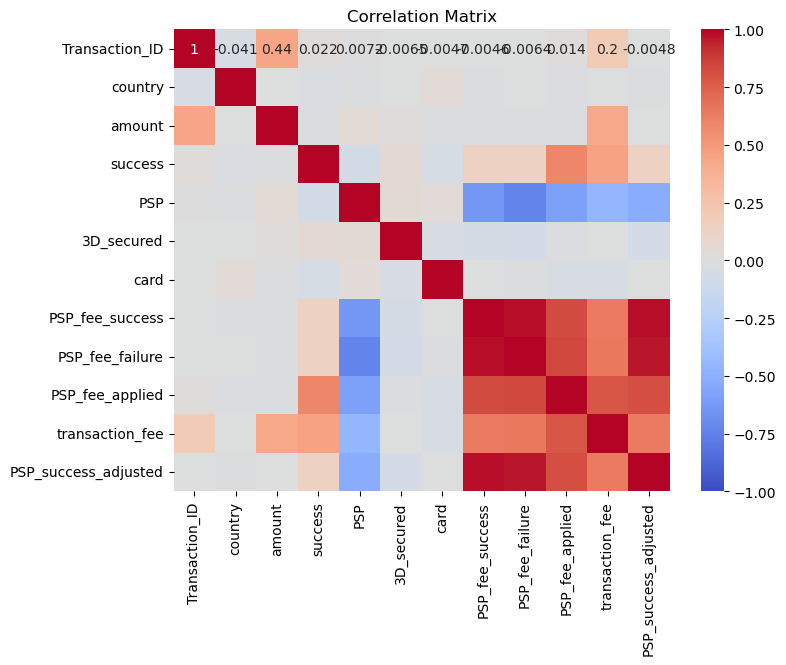

In [16]:
'''Feature selection with techniques: 
correlation matrix
'''

#Correlation matrix
corr_matrix = df_new.corr()
print(corr_matrix)

#Getting correlations between all features and the target variable
target_correlation = corr_matrix['success'].sort_values(ascending=False)

#Printing the outcomes
print("Top positively correlated features with target:")
print(target_correlation[target_correlation > 0.1])  # Threshold of 0.1 for positive correlation

print("\nTop negatively correlated features with target:")
print(target_correlation[target_correlation < -0.1])  # Threshold of -0.1 for negative correlation

#Visualizing the correlation matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show

In [17]:
'''Feature selection with techniques: 
RandomForestClassifier
'''
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
X = df_new[['PSP_fee_applied', 'transaction_fee','country','3D_secured','card','amount','PSP','Transaction_ID','PSP_success_adjusted','PSP_fee_success','PSP_fee_failure' ]]
y = df_new['success']

#Initializing the model
model = RandomForestClassifier()

#Applying RFECV for feature elimination with cross-validation
rfecv = RFECV(estimator=model, step=1, cv=5, scoring='accuracy')
X_rfecv = rfecv.fit_transform(X, y)

#Printing the outcome
print("Optimal number of features:", rfecv.n_features_)

Optimal number of features: 3


In [18]:
'''Feature selection with techniques: 
Benjamini-Hochberg FDR
'''
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
np.random.seed(42)

#Splitting the data based on the target
group1 = df_new[df_new['success'] == 0]
group2 = df_new[df_new['success'] == 1]

#Performing t-tests
p_values = []
for feature in ['PSP_fee_applied', 'transaction_fee','country','3D_secured','card','amount','PSP','Transaction_ID','PSP_success_adjusted','PSP_fee_success','PSP_fee_failure' ]:
    t_stat, p_val = ttest_ind(group1[feature], group2[feature])
    p_values.append(p_val)

#Converting p_values to a numpy array
p_values = np.array(p_values)

#Applying Benjamini-Hochberg FDR control
alpha = 0.05  #FDR threshold
rejected, pvals_corrected, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')

#Creating a result DataFrame
results = pd.DataFrame({
    'Feature': [ 'PSP_fee_applied', 'transaction_fee','country','3D_secured','card','amount','PSP','Transaction_ID','PSP_success_adjusted','PSP_fee_success','PSP_fee_failure' ],
    'P-value': p_values,
    'Corrected P-value': pvals_corrected,
    'Rejected (Significant)': rejected
})

print(results)

                 Feature        P-value  Corrected P-value  \
0        PSP_fee_applied  1.343316e-133      1.477648e-132   
1        transaction_fee   2.924767e-75       1.608622e-74   
2                country   3.534993e-01       4.320547e-01   
3             3D_secured   1.859041e-02       2.921350e-02   
4                   card   4.854051e-02       6.674319e-02   
5                 amount   5.946499e-01       5.946499e-01   
6                    PSP   4.981429e-03       9.132619e-03   
7         Transaction_ID   4.025029e-01       4.427532e-01   
8   PSP_success_adjusted   6.751695e-08       2.475622e-07   
9        PSP_fee_success   1.182333e-07       3.251417e-07   
10       PSP_fee_failure   2.148401e-07       4.726482e-07   

    Rejected (Significant)  
0                     True  
1                     True  
2                    False  
3                     True  
4                    False  
5                    False  
6                     True  
7                    Fa

Selected Features:
 Index(['PSP_fee_applied', 'transaction_fee', 'Transaction_ID',
       'PSP_fee_success'],
      dtype='object')
P-values of Features:
 [1.18379838e-202 0.00000000e+000 4.56163685e-001 4.19456838e-002
 2.15235235e-001 1.59657584e-006 7.47286366e-002 0.00000000e+000
 6.27899249e-001 1.84426035e-010 7.82954979e-007]


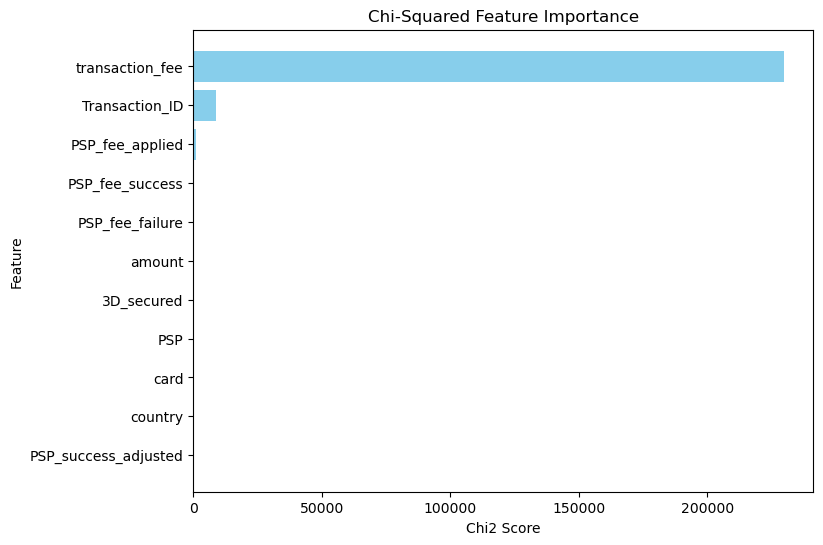

In [19]:
'''Feature selection with techniques: 
Chi-squared
'''
from sklearn.feature_selection import SelectKBest, chi2
X = df_new[['PSP_fee_applied', 'transaction_fee','country','3D_secured','card','amount','PSP','Transaction_ID','PSP_success_adjusted','PSP_fee_success','PSP_fee_failure' ]]
y = df_new['success']

#Performing Chi-Squared test
selector = SelectKBest(chi2, k=4)  #Selecting 4 features
X_new = selector.fit_transform(X, y)

#Getting the chi-squared scores and p-values
chi2_scores = selector.scores_
p_values = selector.pvalues_

#Showing the selected features and p-values
print("Selected Features:\n", X.columns[selector.get_support()])
print("P-values of Features:\n", p_values)
#Creating a DataFrame for visualization
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Chi2 Score': chi2_scores,
    'P-value': p_values
}).sort_values(by='Chi2 Score', ascending=False)

#Bar plot for Chi2 scores
plt.figure(figsize=(8, 6))
plt.barh(feature_scores['Feature'], feature_scores['Chi2 Score'], color='skyblue')
plt.xlabel('Chi2 Score')
plt.ylabel('Feature')
plt.title('Chi-Squared Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [21]:
'''Feature selection with techniques: 
RandomForestClassifier
'''
X = df_new[['PSP_fee_applied', 'transaction_fee','country','3D_secured','card','amount','PSP','Transaction_ID','PSP_success_adjusted','PSP_fee_success','PSP_fee_failure' ]]
y = df_new['success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier()
#Fitting the model
model.fit(X, y)

#Getting feature importances
importances = model.feature_importances_

#Ranking features by importance
important_features = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print(important_features)

PSP_fee_applied         0.612677
transaction_fee         0.198830
amount                  0.039806
PSP_fee_failure         0.036367
PSP_fee_success         0.028969
PSP_success_adjusted    0.024907
Transaction_ID          0.023641
PSP                     0.022106
card                    0.004752
country                 0.004308
3D_secured              0.003638
dtype: float64


Selected features using ANOVA F-Test: Index(['PSP_fee_applied', 'transaction_fee', 'PSP_success_adjusted',
       'PSP_fee_success'],
      dtype='object')
ANOVA F-Test Scores: [7.54564258e+02 3.80418064e+02 8.61419704e-01 5.55240841e+00
 3.89787856e+00 2.83268818e-01 7.91088152e+00 7.01255661e-01
 2.94458696e+01 2.83385265e+01 2.71605222e+01]


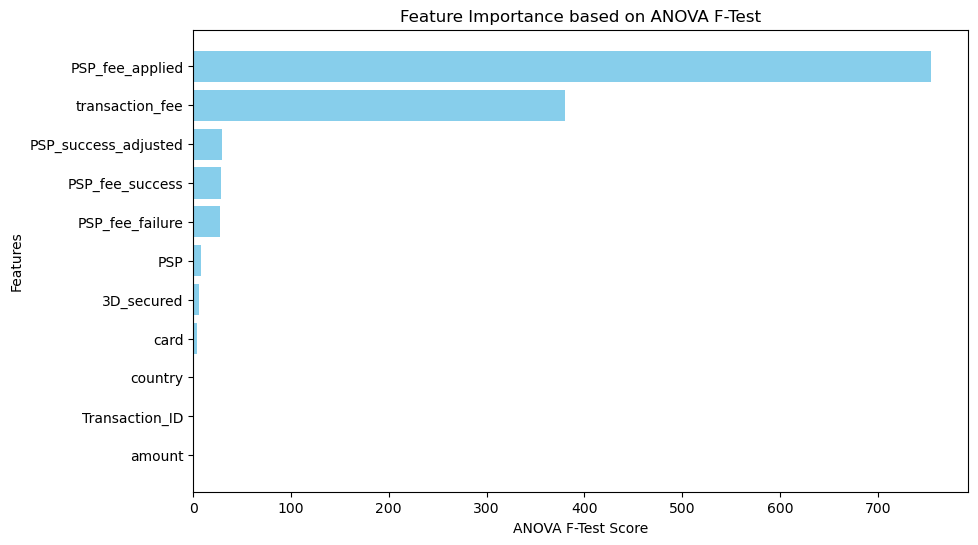

In [23]:
'''Feature selection with techniques: 
ANOVA F-Test
'''
from sklearn.feature_selection import SelectKBest, f_classif

#Applying SelectKBest
f_classif_selector = SelectKBest(score_func=f_classif, k=4)  # Select top 2 features
X_kbest_f_classif = f_classif_selector.fit_transform(X, y)

#Displaying selected feature names and their scores
selected_features_f_classif = X.columns[f_classif_selector.get_support()]
print("Selected features using ANOVA F-Test:", selected_features_f_classif)
print("ANOVA F-Test Scores:", f_classif_selector.scores_)  

#Visualizing the results
features = X.columns
scores = f_classif_selector.scores_

# Sort scores and features in descending order for better visualization
sorted_indices = np.argsort(scores)[::-1]
sorted_scores = scores[sorted_indices]
sorted_features = features[sorted_indices]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_scores, color='skyblue')
plt.xlabel('ANOVA F-Test Score')
plt.ylabel('Features')
plt.title('Feature Importance based on ANOVA F-Test')
plt.gca().invert_yaxis()  
plt.show()

Selected features:
                 Feature  Coefficient
0        PSP_fee_applied     0.571645
8   PSP_success_adjusted    -0.009450
10       PSP_fee_failure    -0.404801


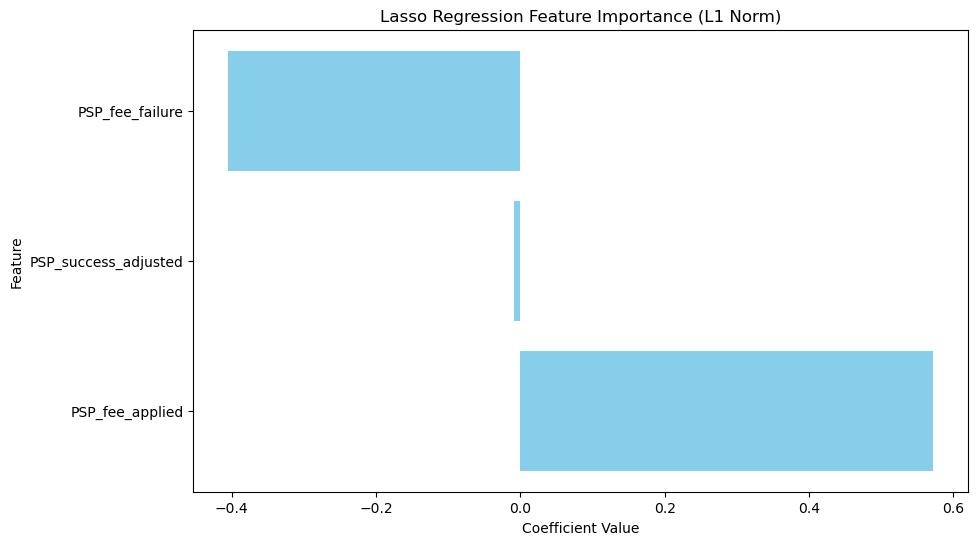

In [24]:
'''Feature selection with techniques: 
L1 Norm
'''
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
#Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#Applying Lasso with L1 regularization
lasso = Lasso(alpha=0.01)  
lasso.fit(X_scaled, y)

#Getting the coefficients
coefficients = lasso.coef_

#Creating a DataFrame to display the features 
feature_importance = pd.DataFrame({
    'Feature': X.columns,  # If X is a DataFrame, otherwise use a list of feature names
    'Coefficient': coefficients
})

#Filtering out features with zero coefficients 
selected_features = feature_importance[feature_importance['Coefficient'] != 0]
print("Selected features:")
print(selected_features)

#Visualizing the outcome
plt.figure(figsize=(10, 6))
plt.barh(selected_features['Feature'], selected_features['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Lasso Regression Feature Importance (L1 Norm)')
plt.show()

In [25]:
'''Building a machine learning model:
Analyze '3D_secured' feature influence
'''
#Filtering the dataset for secured transactions
secured_transactions = df_new[df_new['3D_secured'] == 1]

#Grouping by PSP to calculate the success rate of secured transactions
secured_psp_performance = secured_transactions.groupby('PSP').agg({
    'PSP_success_adjusted': 'mean',           # Calculate success rate
    'amount': 'mean',            # Average amount for secured transactions
    'Transaction_ID': 'count'    # Count of secured transactions
}).reset_index()

#Renaming the columns for clarity
secured_psp_performance.columns = ['PSP', 'secured_success_rate', 'avg_secured_amount', 'secured_transaction_count']


#Calculating success rates for secured and unsecured transactions
secured_vs_unsecured = df_new.groupby('3D_secured').agg({
    'PSP_success_adjusted': 'mean',           # Success rate
    'amount': 'mean',            # Average amount
    'Transaction_ID': 'count'    # Count of transactions
}).reset_index()

#Renaming the columns
secured_vs_unsecured.columns = ['3D_secured', 'success_rate', 'avg_amount', 'transaction_count']

print(secured_vs_unsecured)
print(secured_psp_performance)

   3D_secured  success_rate  avg_amount  transaction_count
0           0      0.100491  242.344309               1063
1           1      0.096329  246.800000                360
   PSP  secured_success_rate  avg_secured_amount  secured_transaction_count
0    0              0.191489          230.769231                         13
1    1              0.109914          234.457627                         59
2    2              0.069014          249.255319                         94
3    3              0.099057          250.438144                        194


In [26]:
'''Building a machine learning model:
A logistic regression model (baseline)
'''
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

features = ['PSP_fee_success', 'PSP_fee_failure','3D_secured','amount','PSP','card','country']
X = df_new[features]
y = df_new['success']

#Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Training the logistic regression model
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)
log_reg.fit(X_train, y_train)

#Predicting the probability of success for each transaction
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

#Converting the predicted probabilities into binary predictions
X_test['final_prediction'] = (y_pred_prob > 0.5).astype(int)

#Evaluating the baseline model's accuracy
accuracy = accuracy_score(y_test, X_test['final_prediction'])
precision = precision_score(y_test, X_test['final_prediction'])
recall = recall_score(y_test, X_test['final_prediction'])
f1 = f1_score(y_test, X_test['final_prediction'])
roc_auc = roc_auc_score(y_test, y_pred_prob)
conf_matrix = confusion_matrix(y_test, X_test['final_prediction'])

#Printing the metrics
print(f"Baseline Logistic Regression Model Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

#Displaying confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)

#Displaying the first predictions
print(X_test[['amount', '3D_secured','PSP', 'final_prediction']].head())


Baseline Logistic Regression Model Metrics:
Accuracy: 0.5684210526315789
Precision: 0.2627118644067797
Recall: 0.4626865671641791
F1 Score: 0.3351351351351352
ROC AUC Score: 0.5946871148842942

Confusion Matrix:
[[131  87]
 [ 36  31]]
       amount  3D_secured  PSP  final_prediction
10979     439           0    1                 1
2785       30           0    3                 0
7926      409           0    0                 1
6111       41           1    2                 0
5400      325           1    1                 1


Random Forest Accuracy: 0.9368421052631579
       Transaction_ID  amount  3D_secured  chosen_psp  final_prediction
10979           10979     439           0         1.0                 1
2785             2785      30           0         3.0                 1
7926             7926     409           0         0.0                 0
6111             6111      41           1         3.0                 1
5400             5400     325           1         3.0                 0
Chosen PSP distribution for secured transactions:
chosen_psp
3.0    78
Name: count, dtype: int64
Baseline Logistic Regression Model Metrics:
Accuracy: 0.9368421052631579
Precision: 0.9152542372881356
Recall: 0.8059701492537313
F1 Score: 0.8571428571428572
ROC AUC Score: 0.9499520744899357

Confusion Matrix:
[[213   5]
 [ 13  54]]


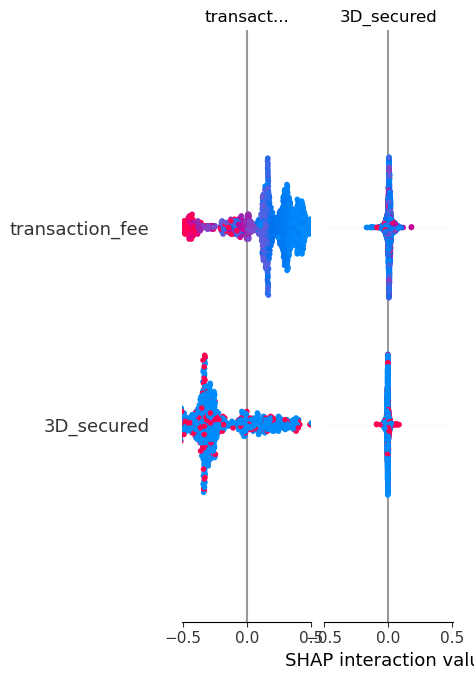

In [28]:
'''Building a machine learning model:
A random forest model (an accurate model)
Applying the outcomes of the '3D_secured' feature
'''
features=['transaction_fee','3D_secured','amount','PSP','Transaction_ID','PSP_success_adjusted','PSP_fee_success','PSP_fee_failure']

X = df_new[features]
y = df_new['success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

#Predicting the probability of success for each transaction
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

#Converting the predicted probabilities into binary predictions (final success prediction)
threshold = 0.3
X_test['final_prediction'] = (y_pred_prob > threshold).astype(int)

#Defining the success rates and fees for each PSP
psp_secured_success_rates = {
    0: 0.191489,  # PSP 0 secured success rate
    1: 0.109914,  # PSP 1 secured success rate
    2: 0.069014,  # PSP 2 secured success rate
    3: 0.099057   # PSP 3 secured success rate
}
#Weights for balancing success rate and fees
alpha = 0.7  # More weight to success rate
beta = 0.3   # Less weight to minimizing fees

#Function to calculate the cost-adjusted score for PSPs
def calculate_psp_score(row, psp_success_rate):
    #Calculating the expected fee (weighted between success and failure fees)
    expected_fee = row['PSP_fee_success'] * row['final_prediction'] + row['PSP_fee_failure'] * (1 - row['final_prediction'])
    
    #Calculate the score: prioritizing success rate, penalizing high fees
    score = alpha * psp_success_rate[row['PSP']] - beta * expected_fee
    return score

#Applying the score calculation for each row based on the PSP
X_test['psp_score'] = X_test.apply(lambda row: calculate_psp_score(row, psp_secured_success_rates), axis=1)

#Defining the logic to choose the best PSP based on 3D-secured status and cost-based scores
def choose_best_psp(row):
    if row['3D_secured'] == 1:
        #Prioritizing PSP 0 for secured transactions, fallback to PSP 3 for bulk or lower-priority transactions
        if row['amount'] <= 250 and psp_secured_success_rates[0] > 0.5:
            return 0  #PSP 0 for smaller secured transactions with high success rate
        elif row['psp_score'] > 0:
            return row['PSP']  #Keeping the current PSP if score is positive
        else:
            return 3  #Using PSP 3 for larger transactions or if no other option is better
    else:
        #For unsecured transactions, keeping the original PSP selection
        return row['PSP']

#Applying the PSP decision logic for each transaction
X_test['chosen_psp'] = X_test.apply(choose_best_psp, axis=1)
#Evaluating the model's performance after applying PSP logic
accuracy = accuracy_score(y_test, X_test['final_prediction'])
print(f"Random Forest Accuracy: {accuracy}")

#Displaying the chosen PSP for each transaction
print(X_test[['Transaction_ID', 'amount', '3D_secured', 'chosen_psp', 'final_prediction']].head())

#Analyzing the distribution of chosen PSPs for secured transactions
secured_transactions = X_test[X_test['3D_secured'] == 1]
psp_choice_counts = secured_transactions['chosen_psp'].value_counts()
print("Chosen PSP distribution for secured transactions:")
print(psp_choice_counts)

#Evaluating the model's accuracy
accuracy = accuracy_score(y_test, X_test['final_prediction'])
precision = precision_score(y_test, X_test['final_prediction'])
recall = recall_score(y_test, X_test['final_prediction'])
f1 = f1_score(y_test, X_test['final_prediction'])
roc_auc = roc_auc_score(y_test, y_pred_prob)
conf_matrix = confusion_matrix(y_test, X_test['final_prediction'])

#Print the metrics
print(f"Baseline Logistic Regression Model Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

#Displaying confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)

#Error analysis with SHAP
import shap
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)



In [36]:
''' Checking the model's outcomes. Creating a new dataset with the outcomes. Cheching the errors'''

#Adding the chosen PSP to the historical data
X_test['historical_psp'] = X_test['PSP']  # Historical PSP column
X_test['chosen_psp'] = X_test.apply(choose_best_psp, axis=1)

#Creating the evaluation table with all relevant columns
evaluation_table = X_test[['Transaction_ID', 'amount', '3D_secured', 'historical_psp', 'chosen_psp', 'final_prediction']]

#Displaying the first few rows of the evaluation table
print(evaluation_table.head())

#Evaluating the model's performance by comparing the final prediction to the true labels
accuracy = accuracy_score(y_test, X_test['final_prediction'])

#Saving the evaluation table to a CSV for further analysis (optional)
evaluation_table.to_csv('psp_evaluation_table.csv', index=False)

#Checking the errors
errors = evaluation_table[evaluation_table['historical_psp'] != evaluation_table['chosen_psp']]
print(errors)

#Overall success of the model
overall_success_rate_historical = evaluation_table['final_prediction'][evaluation_table['historical_psp'] == evaluation_table['chosen_psp']].mean()
overall_success_rate_chosen = evaluation_table['final_prediction'][evaluation_table['historical_psp'] != evaluation_table['chosen_psp']].mean()

print(f"Overall success rate for historical PSP: {overall_success_rate_historical}")
print(f"Overall success rate for chosen PSP: {overall_success_rate_chosen}")


       Transaction_ID  amount  3D_secured  historical_psp  chosen_psp  \
10979           10979     439           0               1         1.0   
2785             2785      30           0               3         3.0   
7926             7926     409           0               0         0.0   
6111             6111      41           1               2         3.0   
5400             5400     325           1               1         3.0   

       final_prediction  
10979                 1  
2785                  1  
7926                  0  
6111                  1  
5400                  0  
       Transaction_ID  amount  3D_secured  historical_psp  chosen_psp  \
6111             6111      41           1               2         3.0   
5400             5400     325           1               1         3.0   
774               774     251           1               2         3.0   
119               119     264           1               2         3.0   
4161             4161     366           